In [ ]:
distress_label = label_encoder.transform(['DISTRESS'])[0]
high_label = label_encoder.transform(['HIGH'])[0]

y_train_binary = ((y_train_final == distress_label) |
                  (y_train_final == high_label)).astype(int)
y_test_binary = ((y_test_final == distress_label) |
                 (y_test_final == high_label)).astype(int)

print(f"À RISQUE: {y_train_binary.sum()} ({y_train_binary.mean():.1%})")
print(f"SOUTENABLE: {(~y_train_binary.astype(bool)).sum()} ({(~y_train_binary.astype(bool)).mean():.1%})")

print(f"À RISQUE: {y_test_binary.sum()} ({y_test_binary.mean():.1%})")
print(f"SOUTENABLE: {(~y_test_binary.astype(bool)).sum()} ({(~y_test_binary.astype(bool)).mean():.1%})")

shift_binary = abs(y_train_binary.mean() - y_test_binary.mean()) * 100
print(f"\n Shift Train-Test: {shift_binary:.1f}%")

À RISQUE: 326 (60.7%)
SOUTENABLE: 211 (39.3%)
À RISQUE: 64 (53.3%)
SOUTENABLE: 56 (46.7%)

 Shift Train-Test: 7.4%


***Random Forest***

In [ ]:
search_spaces_rf = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(10, 30),
    'min_samples_leaf': Integer(5, 15),
    'max_features': Categorical(['sqrt', 'log2']),
    'class_weight': Categorical(['balanced', 'balanced_subsample', None])
}

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

bayes_rf = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_spaces_rf,
    n_iter=25,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_rf.fit(X_train_final, y_train_binary)

cv_results_rf = pd.DataFrame(bayes_rf.cv_results_)
best_idx_rf = bayes_rf.best_index_
train_score_rf = cv_results_rf.loc[best_idx_rf, 'mean_train_score']
test_score_cv_rf = cv_results_rf.loc[best_idx_rf, 'mean_test_score']
gap_rf = train_score_rf - test_score_cv_rf

print(f"   Score CV (F1): {bayes_rf.best_score_:.4f}")
print(f"   Train: {train_score_rf:.4f}")
print(f"   Test (CV): {test_score_cv_rf:.4f}")
print(f"   Gap Train-CV: {gap_rf:.4f}", end="")
if gap_rf < 0.05:
    print("Excellent")
elif gap_rf < 0.10:
    print("Acceptable")
else:
    print("Overfitting")

print(f"\n Meilleurs hyperparamètres RF:")
for param, value in bayes_rf.best_params_.items():
    print(f"{param}: {value}")

   Score CV (F1): 0.9649
   Train: 0.9943
   Test (CV): 0.9649
   Gap Train-CV: 0.0293Excellent

 Meilleurs hyperparamètres RF:
class_weight: None
max_depth: 10
max_features: log2
min_samples_leaf: 5
min_samples_split: 10
n_estimators: 200


***XGBoost***

In [ ]:
n_neg = (y_train_binary == 0).sum()
n_pos = (y_train_binary == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"\n scale_pos_weight: {scale_pos_weight:.2f}")

search_spaces_xgb = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(2, 6),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'subsample': Real(0.6, 0.9),
    'colsample_bytree': Real(0.6, 0.9),
    'gamma': Real(0, 3),
    'reg_alpha': Real(0, 2),
    'reg_lambda': Real(1, 5),
    'min_child_weight': Integer(3, 10),
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

bayes_xgb = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_spaces_xgb,
    n_iter=25,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_xgb.fit(X_train_final, y_train_binary)

cv_results_xgb = pd.DataFrame(bayes_xgb.cv_results_)
best_idx_xgb = bayes_xgb.best_index_
train_score_xgb = cv_results_xgb.loc[best_idx_xgb, 'mean_train_score']
test_score_cv_xgb = cv_results_xgb.loc[best_idx_xgb, 'mean_test_score']
gap_xgb = train_score_xgb - test_score_cv_xgb

print(f"   Score CV (F1): {bayes_xgb.best_score_:.4f}")
print(f"   Train: {train_score_xgb:.4f}")
print(f"   Test (CV): {test_score_cv_xgb:.4f}")
print(f"   Gap Train-CV: {gap_xgb:.4f}", end="")
if gap_xgb < 0.05:
    print("Excellent")
elif gap_xgb < 0.10:
    print("Acceptable")
else:
    print("Overfitting")

print(f"\n Meilleurs hyperparamètres XGBoost:")
for param, value in bayes_xgb.best_params_.items():
    print(f"{param}: {value}")


 scale_pos_weight: 0.65
   Score CV (F1): 0.9678
   Train: 0.9969
   Test (CV): 0.9678
   Gap Train-CV: 0.0292Excellent

 Meilleurs hyperparamètres XGBoost:
colsample_bytree: 0.7377667212318069
gamma: 0.0
learning_rate: 0.1
max_depth: 6
min_child_weight: 3
n_estimators: 262
reg_alpha: 0.3746420887292976
reg_lambda: 5.0
subsample: 0.9


***Evaluation***


 Random Forest:
   Accuracy:  0.7917
   Precision: 0.7746
   Recall:    0.8594
   F1:        0.8148
   AUC:       0.8167
   Confusion: TP=55, FP=16, FN=9, TN=40
   Gap CV-Test: 0.1501Écart important

 XGBoost:
   Accuracy:  0.7250
   Precision: 0.7541
   Recall:    0.7188
   F1:        0.7360
   AUC:       0.7916
   Confusion: TP=46, FP=15, FN=18, TN=41
   Gap CV-Test: 0.2318Écart important

TABLEAU COMPARATIF COMPLET
       Modèle  CV_Score   CV_Gap  Test_F1  Test_AUC  Test_Recall  Test_Precision  CV_Test_Gap
Random Forest  0.964941 0.029324 0.814815  0.816685     0.859375        0.774648     0.150126
      XGBoost  0.967770 0.029161 0.736000  0.791574     0.718750        0.754098     0.231770
   • CV_Gap: Écart Train-CV (overfitting interne)
   • CV_Test_Gap: Écart CV-Test final (généralisation)
   • |CV_Test_Gap| < 0.05 = Excellent
   • |CV_Test_Gap| < 0.10 = Acceptable

 Meilleur modèle (F1 Test): Random Forest
   Test F1: 0.8148
   Test AUC: 0.8167
   Test Recall: 85.94%
   Gap C

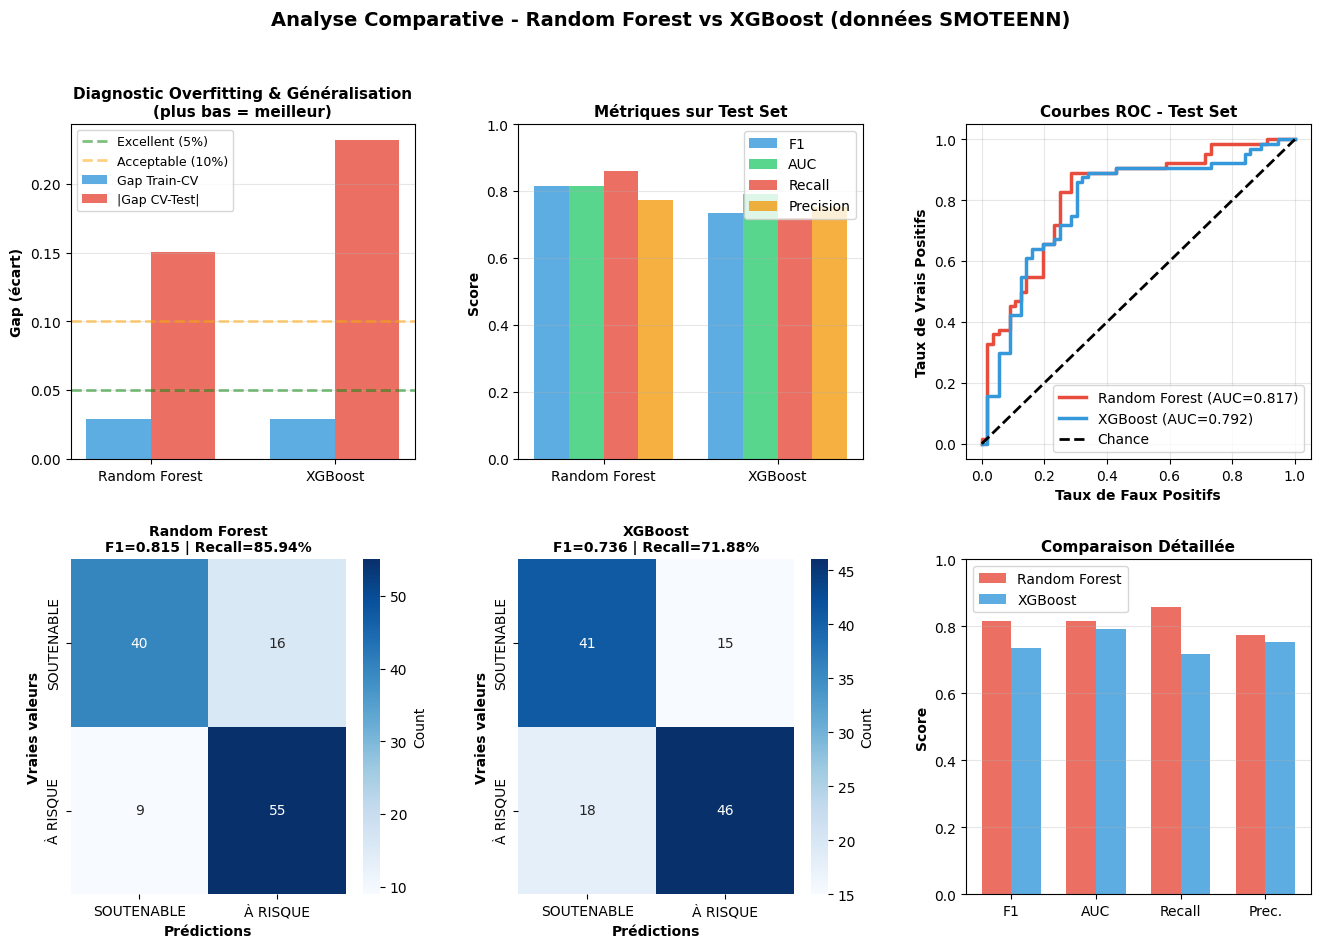


              precision    recall  f1-score   support

  SOUTENABLE     0.8163    0.7143    0.7619        56
    À RISQUE     0.7746    0.8594    0.8148        64

    accuracy                         0.7917       120
   macro avg     0.7955    0.7868    0.7884       120
weighted avg     0.7941    0.7917    0.7901       120


 Feature Importance:
              Feature  Importance
    External_Debt_GDP    0.219748
Corruption_Governance    0.196979
        Exchange_Rate    0.157292
 Debt_Service_Exports    0.135442
     Net_ODA_received    0.118809
           GDP_Growth    0.088195
      Current_Account    0.083535

 Le meilleure modèle: Random Forest
Gap CV-Test: 0.1501Problématique
AUC Test: 0.8167Excellente
Recall Test: 85.94%Excellente


In [ ]:
models = {
    'Random Forest': bayes_rf.best_estimator_,
    'XGBoost': bayes_xgb.best_estimator_
}

results = []

for name, model in models.items():
    print(f"\n {name}:")

    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]

    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred)
    recall = recall_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_pred_proba)

    cm = confusion_matrix(y_test_binary, y_pred)
    tn, fp, fn, tp = cm.ravel()

    if name == 'Random Forest':
        cv_score = bayes_rf.best_score_
        gap = gap_rf
    else:
        cv_score = bayes_xgb.best_score_
        gap = gap_xgb

    test_gap = cv_score - f1

    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1:        {f1:.4f}")
    print(f"   AUC:       {auc:.4f}")
    print(f"   Confusion: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    print(f"   Gap CV-Test: {test_gap:.4f}", end="")
    if abs(test_gap) < 0.05:
        print("Excellent")
    elif abs(test_gap) < 0.10:
        print("Acceptable")
    else:
        print("Écart important")

    results.append({
        'Modèle': name,
        'CV_Score': cv_score,
        'CV_Gap': gap,
        'Test_F1': f1,
        'Test_AUC': auc,
        'Test_Recall': recall,
        'Test_Precision': precision,
        'Test_Accuracy': accuracy,
        'CV_Test_Gap': test_gap,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    })

results_df = pd.DataFrame(results)


print(results_df[['Modèle', 'CV_Score', 'CV_Gap', 'Test_F1', 'Test_AUC',
                  'Test_Recall', 'Test_Precision', 'CV_Test_Gap']].to_string(index=False))


best_model_name = results_df.loc[results_df['Test_F1'].idxmax(), 'Modèle']
best_model_row = results_df.loc[results_df['Test_F1'].idxmax()]

print(f"\n Meilleur modèle (F1 Test): {best_model_name}")
print(f"Test F1: {best_model_row['Test_F1']:.4f}")
print(f"Test AUC: {best_model_row['Test_AUC']:.4f}")
print(f"Test Recall: {best_model_row['Test_Recall']:.2%}")
print(f"Gap CV-Test: {best_model_row['CV_Test_Gap']:.4f}")



fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
x_pos = np.arange(len(results_df))
width = 0.35

ax.bar(x_pos - width/2, results_df['CV_Gap'], width,
       label='Gap Train-CV', alpha=0.8, color='#3498db')
ax.bar(x_pos + width/2, np.abs(results_df['CV_Test_Gap']), width,
       label='|Gap CV-Test|', alpha=0.8, color='#e74c3c')

ax.axhline(y=0.05, color='green', linestyle='--', lw=2, alpha=0.5,
           label='Excellent (5%)')
ax.axhline(y=0.10, color='orange', linestyle='--', lw=2, alpha=0.5,
           label='Acceptable (10%)')

ax.set_ylabel('Gap (écart)', fontweight='bold')
ax.set_title('Diagnostic Overfitting & Généralisation\n(plus bas = meilleur)',
             fontweight='bold', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Modèle'])
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

ax = fig.add_subplot(gs[0, 1])
metrics = ['Test_F1', 'Test_AUC', 'Test_Recall', 'Test_Precision']
x = np.arange(len(results_df))
width = 0.2

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
for i, (metric, color) in enumerate(zip(metrics, colors)):
    offset = (i - len(metrics)/2) * width + width/2
    ax.bar(x + offset, results_df[metric], width,
           label=metric.replace('Test_', ''), alpha=0.8, color=color)

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Métriques sur Test Set', fontweight='bold', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Modèle'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])


ax = fig.add_subplot(gs[0, 2])
colors_roc = ['#e74c3c', '#3498db']
for (name, model), color in zip(models.items(), colors_roc):
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    auc_score = results_df[results_df['Modèle']==name]['Test_AUC'].values[0]
    ax.plot(fpr, tpr, lw=2.5, label=f'{name} (AUC={auc_score:.3f})', color=color)

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
ax.set_xlabel('Taux de Faux Positifs', fontweight='bold')
ax.set_ylabel('Taux de Vrais Positifs', fontweight='bold')
ax.set_title('Courbes ROC - Test Set', fontweight='bold', fontsize=11)
ax.legend()
ax.grid(alpha=0.3)


for idx, (name, model) in enumerate(models.items()):
    ax = fig.add_subplot(gs[1, idx])

    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test_binary, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['SOUTENABLE', 'À RISQUE'],
                yticklabels=['SOUTENABLE', 'À RISQUE'],
                ax=ax, cbar_kws={'label': 'Count'})

    f1_val = results_df[results_df['Modèle']==name]['Test_F1'].values[0]
    recall_val = results_df[results_df['Modèle']==name]['Test_Recall'].values[0]

    ax.set_xlabel('Prédictions', fontweight='bold')
    ax.set_ylabel('Vraies valeurs', fontweight='bold')
    ax.set_title(f'{name}\nF1={f1_val:.3f} | Recall={recall_val:.2%}',
                 fontsize=10, fontweight='bold')


ax = fig.add_subplot(gs[1, 2])

categories = ['F1', 'AUC', 'Recall', 'Prec.']
rf_scores = [results_df[results_df['Modèle']=='Random Forest']['Test_F1'].values[0],
             results_df[results_df['Modèle']=='Random Forest']['Test_AUC'].values[0],
             results_df[results_df['Modèle']=='Random Forest']['Test_Recall'].values[0],
             results_df[results_df['Modèle']=='Random Forest']['Test_Precision'].values[0]]

xgb_scores = [results_df[results_df['Modèle']=='XGBoost']['Test_F1'].values[0],
              results_df[results_df['Modèle']=='XGBoost']['Test_AUC'].values[0],
              results_df[results_df['Modèle']=='XGBoost']['Test_Recall'].values[0],
              results_df[results_df['Modèle']=='XGBoost']['Test_Precision'].values[0]]

x = np.arange(len(categories))
width = 0.35

ax.bar(x - width/2, rf_scores, width, label='Random Forest',
       alpha=0.8, color='#e74c3c')
ax.bar(x + width/2, xgb_scores, width, label='XGBoost',
       alpha=0.8, color='#3498db')

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Comparaison Détaillée', fontweight='bold', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.suptitle('Analyse Comparative - Random Forest vs XGBoost (données SMOTEENN)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


best_model = models[best_model_name]
y_pred_final = best_model.predict(X_test_final)

print("\n" + classification_report(y_test_binary, y_pred_final,
                                   target_names=['SOUTENABLE', 'À RISQUE'],
                                   digits=4))


if hasattr(best_model, 'feature_importances_'):
    print("\n Feature Importance:")
    importances = best_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_imp_df.to_string(index=False))


print(f"\n Le meilleure modèle: {best_model_name}")

print(f"Gap CV-Test: {best_model_row['CV_Test_Gap']:.4f}", end="")
if abs(best_model_row['CV_Test_Gap']) < 0.05:
    print("Excellente")
elif abs(best_model_row['CV_Test_Gap']) < 0.10:
    print("Acceptable")
else:
    print("Problématique")

print(f"AUC Test: {best_model_row['Test_AUC']:.4f}", end="")
if best_model_row['Test_AUC'] >= 0.80:
    print("Excellente")
elif best_model_row['Test_AUC'] >= 0.75:
    print("Bonne")
elif best_model_row['Test_AUC'] >= 0.70:
    print("Acceptable")
else:
    print("Insuffisante")

print(f"Recall Test: {best_model_row['Test_Recall']:.2%}", end="")
if best_model_row['Test_Recall'] >= 0.75:
    print("Excellente")
elif best_model_row['Test_Recall'] >= 0.65:
    print("Acceptable")
else:
    print("Trop de cas ratés")
